In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/Nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='Nanum')
matplotlib.font_manager._rebuild()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체
print(device)

cuda:0


In [3]:
from PIL import Image
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
car_dir = './class_1st/train'
categories = os.listdir(car_dir)
categories.remove('.DS_Store')
nb_classes = len(categories)
print(nb_classes, categories)

33 ['현대 코나', '쌍용 렉스턴 스포츠', '현대 코나 일렉트릭', '르노삼성 SM6', '기아 K7 하이브리드 YG', '현대 싼타페TM', '제네시스 G80', '기아 니로', '기아 레이', '현대 팰리 세이드', '현대 그랜저 하이브리드 IG', '기아 K7 YG', '기아 봉고3', '제네시스 G90', '현대 그랜저 IG', '쌍용 G4 렉스턴', '기아 셀토스', '현대 코나 하이브리드', '기아 모하비', '현대 그랜드 스타렉스', '현대 포터2', '쉐보레 트랙스', '기아 모닝 JA', '현대 LF 쏘나타', '기아 카니발', '기아 쏘렌토', '기아 K5 JF', '쉐보레 스파크', '르노삼성 QM3', '기아 K3 BD', '쌍용 티볼리', '르노삼성 QM6', '현대 베뉴']


In [6]:
# 이미지 크기 지정
image_w = 380
image_h = 380
pixels = image_w * image_h *3

In [13]:
transforms_train = transforms.Compose([
    transforms.Resize((image_w, image_h)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((image_w, image_h)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# transforms_val = transforms.Compose([
#     transforms.Resize((380, 380), Image.ANTIALIAS),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
data_dir = './class_1st'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)
# val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms_val)


train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=16, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=16, shuffle=True, num_workers=4)
# val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=12, shuffle=True, num_workers=4)

class_names = train_datasets.classes
class_cnt = len(class_names)


print('학습 데이터셋 크기:', len(train_datasets))
print('차종 모델명 :', class_names)
print('차종 개수 : ', class_cnt )

학습 데이터셋 크기: 5035
차종 모델명 :
차종 개수 :  33


In [14]:
# category 정보 저장(모델 저장 후 카테고리 정보 불러올 때 필요함)
import pandas as pd
categories=pd.DataFrame(class_names)
categories.to_csv('./class_1st/categories.csv', header=False,index=False)

In [7]:
#pip install efficientnet_pytorch

In [12]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')

Loaded pretrained weights for efficientnet-b4


In [13]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [14]:
# model = models.efficientnetb0(pretrained=True)
num_features = model._fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 6개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, class_cnt)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
num_epochs = 20
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
 
        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 5.2036 Acc: 14.0616% Time: 165.3030s
#1 Loss: 2.1826 Acc: 50.6455% Time: 330.6201s
#2 Loss: 1.1421 Acc: 72.7309% Time: 495.9670s
#3 Loss: 0.7481 Acc: 81.2314% Time: 661.2549s
#4 Loss: 0.5340 Acc: 86.7527% Time: 826.5691s
#5 Loss: 0.3949 Acc: 90.0497% Time: 991.9041s
#6 Loss: 0.3115 Acc: 92.2741% Time: 1157.2558s
#7 Loss: 0.2548 Acc: 93.8630% Time: 1322.5751s
#8 Loss: 0.2048 Acc: 95.2532% Time: 1488.0313s
#9 Loss: 0.1636 Acc: 96.1867% Time: 1653.5162s
#10 Loss: 0.1465 Acc: 96.8024% Time: 1819.0021s
#11 Loss: 0.1119 Acc: 97.4777% Time: 1984.3928s
#12 Loss: 0.0982 Acc: 97.7756% Time: 2149.7289s
#13 Loss: 0.0916 Acc: 97.9146% Time: 2315.0953s
#14 Loss: 0.0865 Acc: 97.8749% Time: 2480.4677s
#15 Loss: 0.0698 Acc: 98.4707% Time: 2645.8032s
#16 Loss: 0.0685 Acc: 98.5104% Time: 2811.1690s
#17 Loss: 0.0631 Acc: 98.4707% Time: 2976.5235s
#18 Loss: 0.0509 Acc: 98.9076% Time: 3141.8765s
#19 Loss: 0.0515 Acc: 98.9076% Time: 3307.2405s


In [25]:
num_epochs = 5
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.0362 Acc: 99.0864% Time: 165.4857s
#1 Loss: 0.0351 Acc: 99.3843% Time: 330.8354s
#2 Loss: 0.0306 Acc: 99.4836% Time: 496.1959s
#3 Loss: 0.0314 Acc: 99.3247% Time: 661.5572s
#4 Loss: 0.0274 Acc: 99.4638% Time: 826.9274s


In [28]:
# 모델 저장
torch.save(model, './models/car_efficient_b4_ver02_30.ph')

In [ ]:
model = torch.load('./models/car_efficient_b4_ver01.ph')

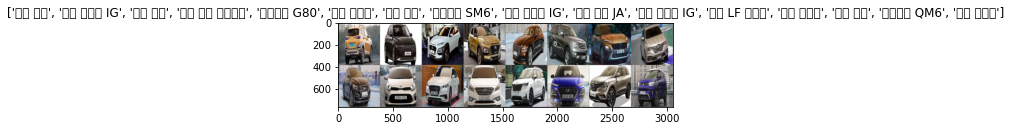

In [26]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

[예측 결과: 현대 베뉴] (실제 정답: 현대 베뉴)


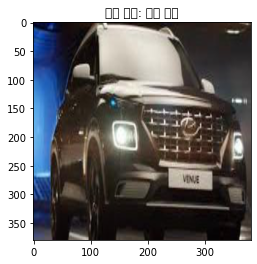

[예측 결과: 르노삼성 QM3] (실제 정답: 르노삼성 QM3)


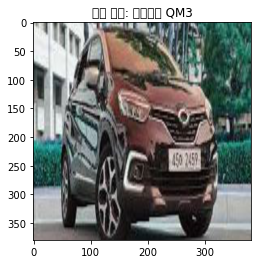

[예측 결과: 기아 모닝 JA] (실제 정답: 기아 모닝 JA)


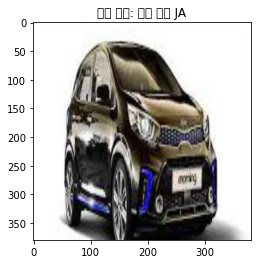

[예측 결과: 기아 셀토스] (실제 정답: 기아 셀토스)


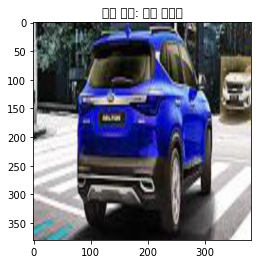

[예측 결과: 제네시스 G80] (실제 정답: 제네시스 G80)


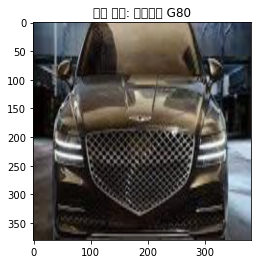

[예측 결과: 기아 K7 YG] (실제 정답: 기아 K7 YG)


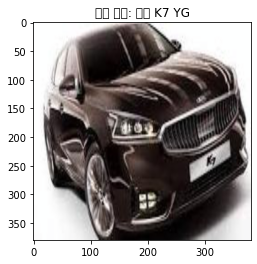

[예측 결과: 쌍용 G4 렉스턴] (실제 정답: 쌍용 G4 렉스턴)


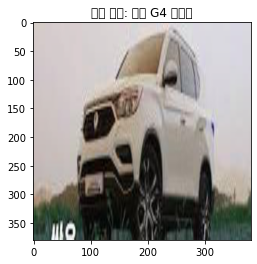

[예측 결과: 현대 코나] (실제 정답: 현대 코나)


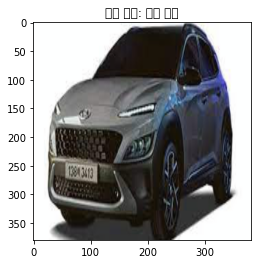

[예측 결과: 기아 K7 YG] (실제 정답: 기아 K7 YG)


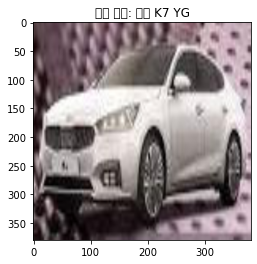

[예측 결과: 르노삼성 SM6] (실제 정답: 르노삼성 SM6)


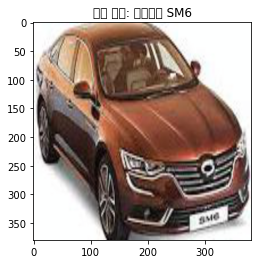

[예측 결과: 기아 모하비] (실제 정답: 기아 모하비)


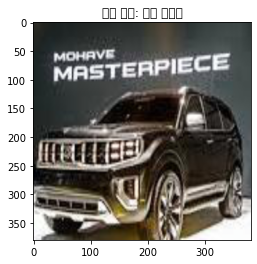

[예측 결과: 기아 봉고3] (실제 정답: 기아 봉고3)


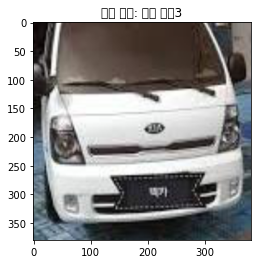

[예측 결과: 현대 베뉴] (실제 정답: 현대 베뉴)


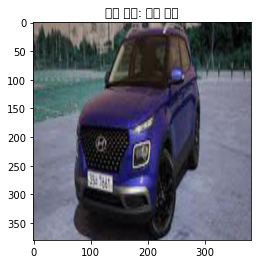

[예측 결과: 르노삼성 SM6] (실제 정답: 르노삼성 SM6)


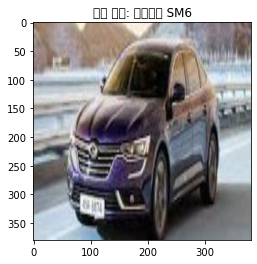

[예측 결과: 쉐보레 스파크] (실제 정답: 쉐보레 스파크)


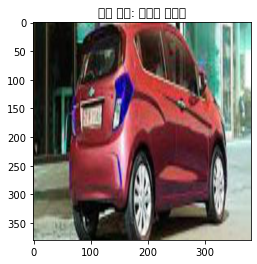

[예측 결과: 기아 모닝 JA] (실제 정답: 기아 모닝 JA)


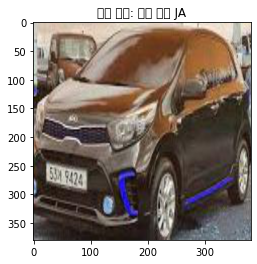

[예측 결과: 르노삼성 QM3] (실제 정답: 르노삼성 QM3)


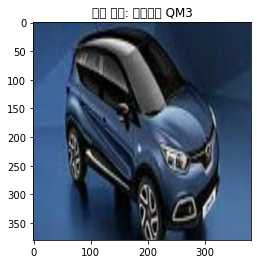

[예측 결과: 현대 팰리 세이드] (실제 정답: 현대 팰리 세이드)


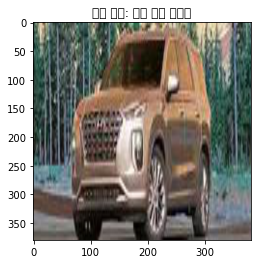

[예측 결과: 현대 그랜저 IG] (실제 정답: 현대 그랜저 IG)


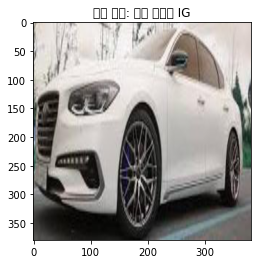

[예측 결과: 현대 팰리 세이드] (실제 정답: 현대 팰리 세이드)


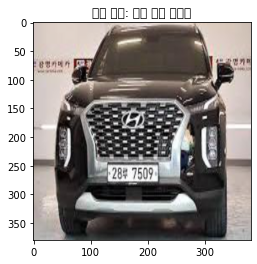

[예측 결과: 기아 K7 YG] (실제 정답: 기아 K7 YG)


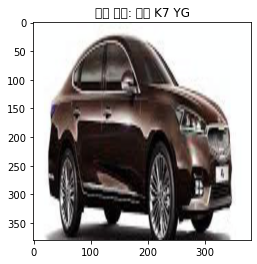

[예측 결과: 르노삼성 QM3] (실제 정답: 르노삼성 QM3)


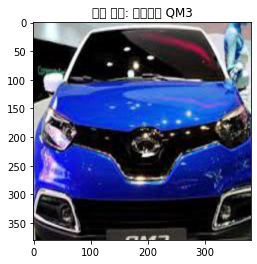

[예측 결과: 기아 K7 YG] (실제 정답: 기아 K7 YG)


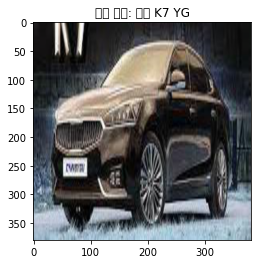

[예측 결과: 현대 코나 일렉트릭] (실제 정답: 현대 코나 일렉트릭)


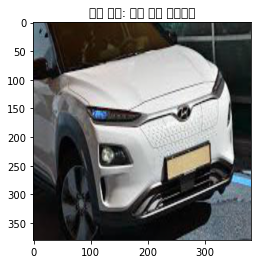

[예측 결과: 제네시스 G90] (실제 정답: 제네시스 G90)


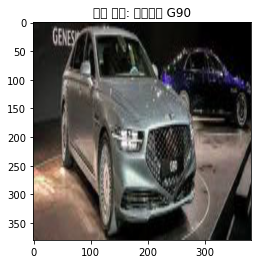

[예측 결과: 쉐보레 스파크] (실제 정답: 쉐보레 스파크)


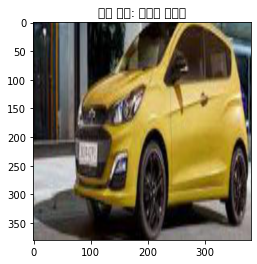

[예측 결과: 현대 그랜저 IG] (실제 정답: 현대 그랜저 IG)


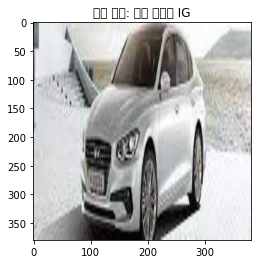

[예측 결과: 르노삼성 QM3] (실제 정답: 르노삼성 QM3)


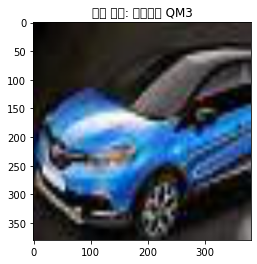

[예측 결과: 기아 K5 JF] (실제 정답: 기아 K5 JF)


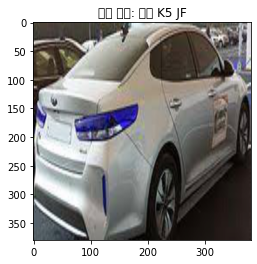

[예측 결과: 쉐보레 트랙스] (실제 정답: 쉐보레 트랙스)


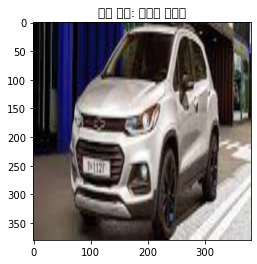

[예측 결과: 르노삼성 QM3] (실제 정답: 르노삼성 QM3)


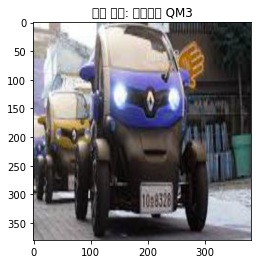

[예측 결과: 현대 코나] (실제 정답: 현대 코나)


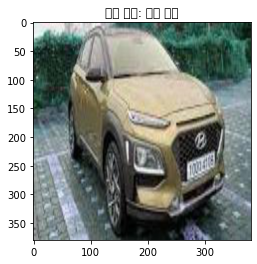

[예측 결과: 기아 모닝 JA] (실제 정답: 기아 모닝 JA)


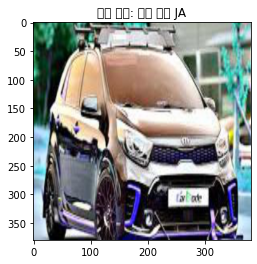

[예측 결과: 르노삼성 SM6] (실제 정답: 르노삼성 SM6)


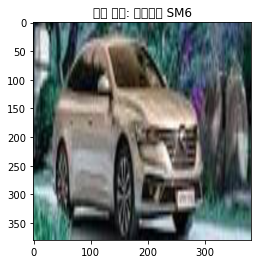

[예측 결과: 기아 쏘렌토] (실제 정답: 기아 쏘렌토)


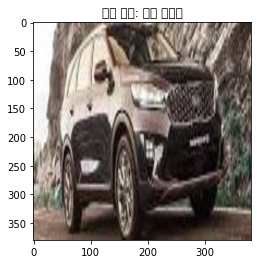

[예측 결과: 현대 LF 쏘나타] (실제 정답: 현대 LF 쏘나타)


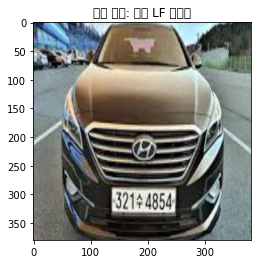

[예측 결과: 르노삼성 QM3] (실제 정답: 르노삼성 QM6)


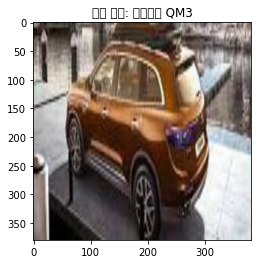

[예측 결과: 르노삼성 QM3] (실제 정답: 르노삼성 QM3)


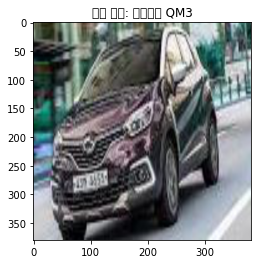

[예측 결과: 르노삼성 SM6] (실제 정답: 르노삼성 SM6)


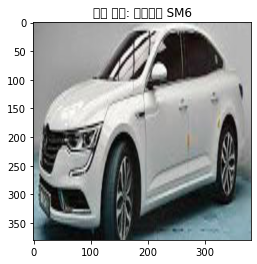

[예측 결과: 현대 그랜저 IG] (실제 정답: 현대 그랜저 IG)


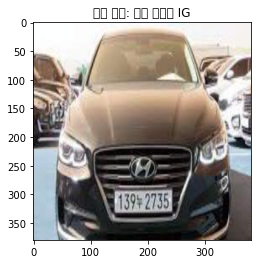

[예측 결과: 기아 K3 BD] (실제 정답: 기아 K7 YG)


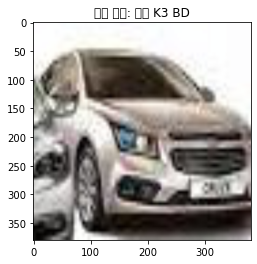

[예측 결과: 기아 니로] (실제 정답: 기아 니로)


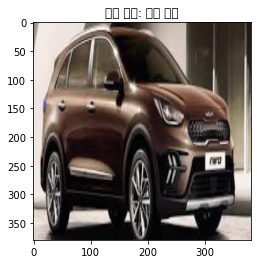

[예측 결과: 르노삼성 SM6] (실제 정답: 르노삼성 SM6)


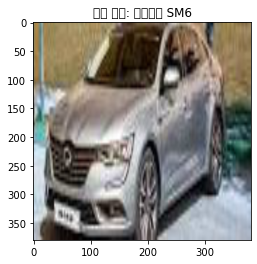

[예측 결과: 기아 카니발] (실제 정답: 기아 카니발)


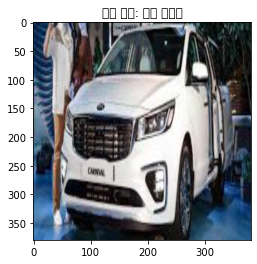

[예측 결과: 기아 모닝 JA] (실제 정답: 기아 모닝 JA)


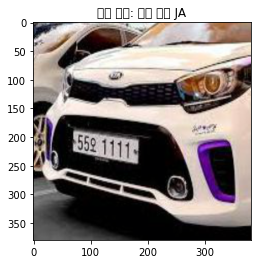

[예측 결과: 쌍용 렉스턴 스포츠] (실제 정답: 쌍용 렉스턴 스포츠)


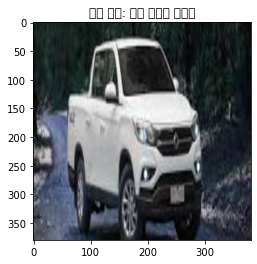

[예측 결과: 쌍용 G4 렉스턴] (실제 정답: 쌍용 G4 렉스턴)


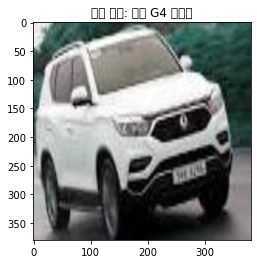

[예측 결과: 기아 모닝 JA] (실제 정답: 기아 모닝 JA)


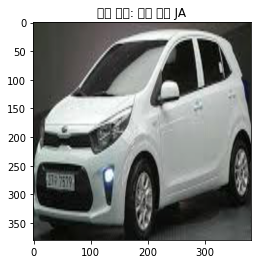

[예측 결과: 현대 LF 쏘나타] (실제 정답: 현대 LF 쏘나타)


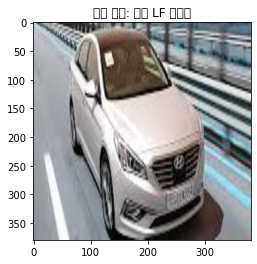

[예측 결과: 현대 코나 일렉트릭] (실제 정답: 현대 코나 일렉트릭)


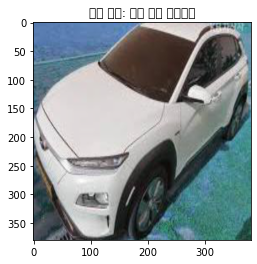

[예측 결과: 현대 그랜드 스타렉스] (실제 정답: 현대 그랜드 스타렉스)


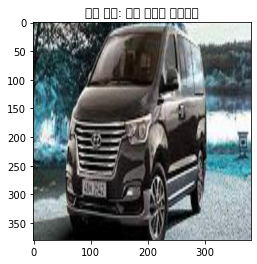

[예측 결과: 현대 코나] (실제 정답: 현대 코나)


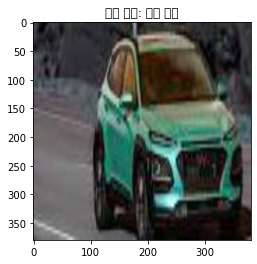

[예측 결과: 기아 셀토스] (실제 정답: 기아 셀토스)


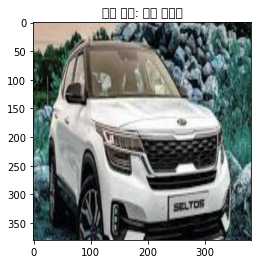

[예측 결과: 르노삼성 SM6] (실제 정답: 르노삼성 SM6)


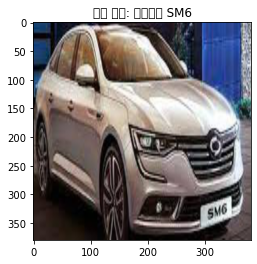

[예측 결과: 쌍용 렉스턴 스포츠] (실제 정답: 쌍용 렉스턴 스포츠)


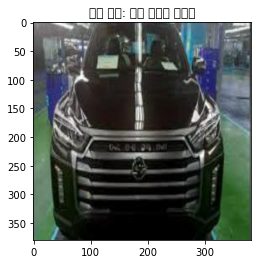

[예측 결과: 제네시스 G90] (실제 정답: 제네시스 G90)


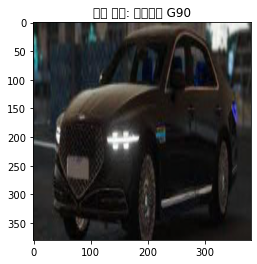

[예측 결과: 기아 K7 YG] (실제 정답: 기아 K7 YG)


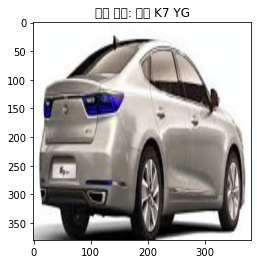

[예측 결과: 르노삼성 SM6] (실제 정답: 르노삼성 SM6)


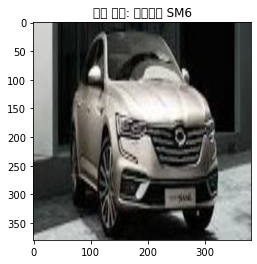

[예측 결과: 기아 카니발] (실제 정답: 기아 카니발)


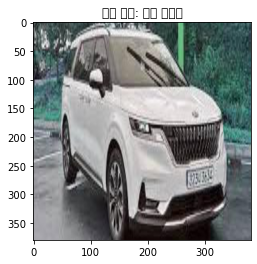

[예측 결과: 쉐보레 트랙스] (실제 정답: 쉐보레 트랙스)


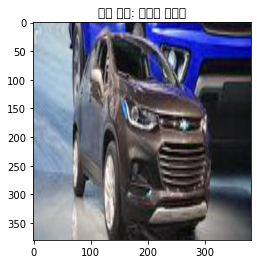

[예측 결과: 현대 코나] (실제 정답: 현대 코나)


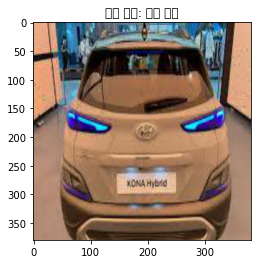

[예측 결과: 현대 코나] (실제 정답: 현대 코나)


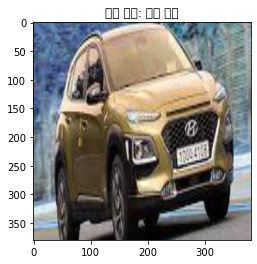

[예측 결과: 쉐보레 스파크] (실제 정답: 쉐보레 스파크)


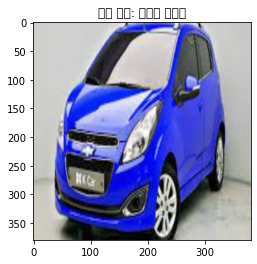

[예측 결과: 쌍용 G4 렉스턴] (실제 정답: 쌍용 G4 렉스턴)


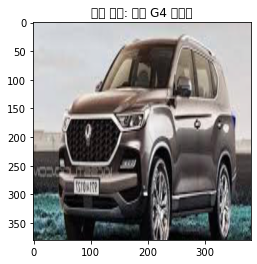

[예측 결과: 기아 카니발] (실제 정답: 기아 카니발)


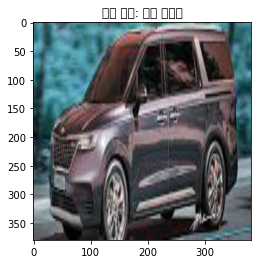

[예측 결과: 현대 코나 일렉트릭] (실제 정답: 현대 코나 일렉트릭)


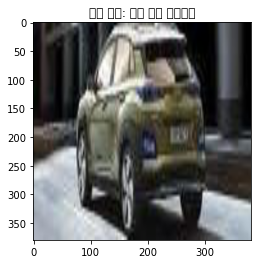

[예측 결과: 현대 코나 일렉트릭] (실제 정답: 현대 코나 일렉트릭)


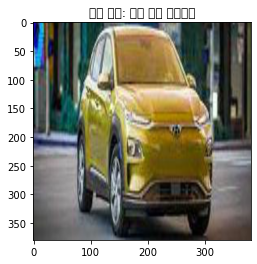

[예측 결과: 현대 싼타페TM] (실제 정답: 현대 싼타페TM)


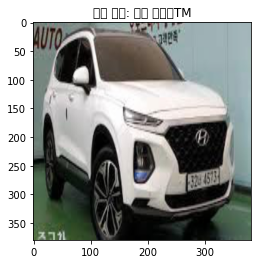

[예측 결과: 현대 코나] (실제 정답: 현대 코나)


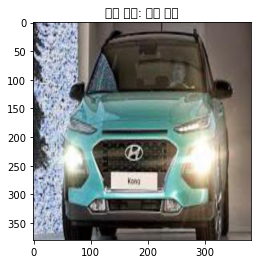

[예측 결과: 기아 쏘렌토] (실제 정답: 기아 쏘렌토)


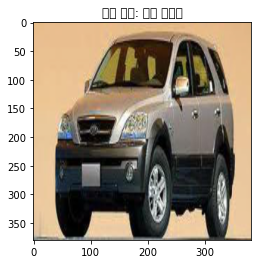

[예측 결과: 기아 레이] (실제 정답: 기아 레이)


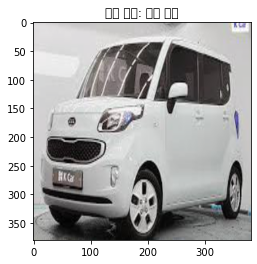

[예측 결과: 르노삼성 QM6] (실제 정답: 현대 싼타페TM)


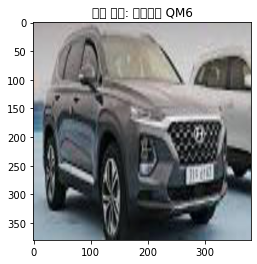

[예측 결과: 현대 팰리 세이드] (실제 정답: 현대 팰리 세이드)


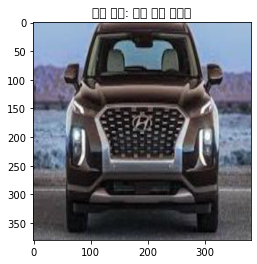

[예측 결과: 르노삼성 QM3] (실제 정답: 르노삼성 QM3)


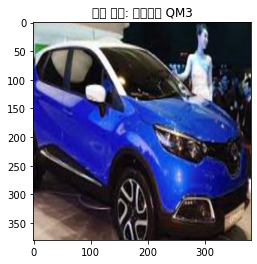

[예측 결과: 르노삼성 QM3] (실제 정답: 르노삼성 QM3)


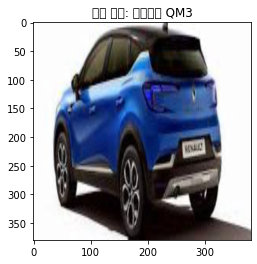

[예측 결과: 기아 K7 YG] (실제 정답: 기아 K7 YG)


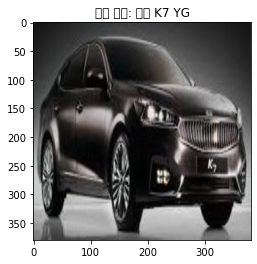

[Test Phase] Loss: 0.3394 Acc: 93.0464% Time: 23.2360s


In [27]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))